In [7]:
#@title import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('dark_background' )
from cycler import cycler       # cycler(linestyle=['-','--',':','-.') * cycler(color=colors) cycler(lw=[1,5])
plt.rc('axes', prop_cycle=cycler(color=list('rbygmcw')+['orangered', 'gray', 'gold','coral']))

import os
import sys

from scipy import stats
from scipy.signal import savgol_filter
from scipy.ndimage import generic_filter
from scipy.signal import freqz
from scipy.signal import butter, lfilter

from google.colab import drive
drive.mount('/gdrive')

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [8]:
#@title load X, y

!ln -s /gdrive/MyDrive/korobool/3_model/data data
!ls


ln: failed to create symbolic link 'data/data': File exists
data  sample_data


In [10]:
X_data = np.load('data/x_all.npy')
y_data = np.load('data/y_all.npy')
print(f'N={len(y_data)};    x_data = {X_data.shape};    y_data= {y_data.shape}')

N=263;    x_data = (263, 297, 18);    y_data= (263, 297, 2)


In [11]:
WS = 13
window_size = WS

y_train shape before one-hot encoding: (223, 297, 2)
y_test shape before one-hot encoding: (40, 297, 2)
y_train shape after one-hot encoding: (223, 297, 6)
y_test shape after one-hot encoding: (40, 297, 6)
Epoch 1/130
23/23 [==============================] - 16s 59ms/step - loss: 1.0597 - val_loss: 0.3125
Epoch 2/130
23/23 [==============================] - 1s 25ms/step - loss: 0.2498 - val_loss: 0.2208
Epoch 3/130
23/23 [==============================] - 1s 25ms/step - loss: 0.2106 - val_loss: 0.2030
Epoch 4/130
23/23 [==============================] - 1s 25ms/step - loss: 0.2006 - val_loss: 0.1974
Epoch 5/130
23/23 [==============================] - 1s 26ms/step - loss: 0.1957 - val_loss: 0.1935
Epoch 6/130
23/23 [==============================] - 1s 26ms/step - loss: 0.1920 - val_loss: 0.1896
Epoch 7/130
23/23 [==============================] - 1s 25ms/step - loss: 0.1888 - val_loss: 0.1884
Epoch 8/130
23/23 [==============================] - 1s 25ms/step - loss: 0.1861 - val_loss: 

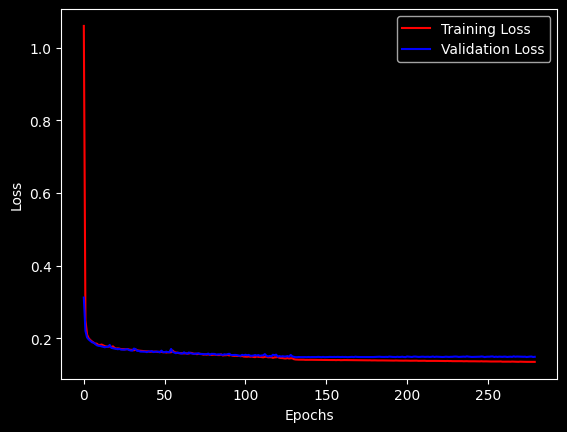

2/2 [==============================] - 1s 10ms/step
Predicted signal shape: (40, 297)
Predicted segmentation shape: (40, 297)


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Lambda

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# # Load your data
# X_data = np.load('/gdrive/MyDrive/korobool/seq2seq/X_data_file.npy')
# y_data = np.load('/gdrive/MyDrive/korobool/seq2seq/y_mask_data_file.npy')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.15, random_state=42)


print("y_train shape before one-hot encoding:", y_train.shape)
print("y_test shape before one-hot encoding:", y_test.shape)

y_train_segmentation = to_categorical(y_train[:, :, 1], num_classes=5)
y_test_segmentation = to_categorical(y_test[:, :, 1], num_classes=5)

y_train = np.concatenate([y_train[:, :, :1], y_train_segmentation], axis=-1)
y_test = np.concatenate([y_test[:, :, :1], y_test_segmentation], axis=-1)

print("y_train shape after one-hot encoding:", y_train.shape)
print("y_test shape after one-hot encoding:", y_test.shape)


def transformer_encoder(inputs, num_heads=8, dff=2048, rate=0.01):
    x = inputs
    for _ in range(4):  # Increase the number of layers for a deeper model
        attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
        attn_output = Dropout(rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(dff, activation='relu', kernel_regularizer=l2(1e-4))(out1)  # Apply L2 regularization
        ffn_output = Dense(x.shape[-1], kernel_regularizer=l2(1e-4))(ffn_output)  # Apply L2 regularization
        ffn_output = Dropout(rate)(ffn_output)

        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return x

def tf_moving_average(data, window_size):
    kernel = tf.ones(window_size) / tf.cast(window_size, data.dtype)
    kernel = tf.reshape(kernel, [window_size, 1, 1])
    return tf.nn.conv1d(tf.expand_dims(data, axis=-1), kernel, stride=1, padding='VALID')


def custom_loss(y_true, y_pred, alpha=0.1, beta=0.1, window_size=WS):
    y_true_signal = y_true[:, :-1, 0]
    y_pred_signal = y_pred[:, :, 0]

    # y_pred_signal = tf.maximum(y_pred_signal, 0)

    y_pred_smoothed_signal = tf_moving_average(y_pred_signal, window_size)
    y_true_cropped_signal = y_true_signal[:, (window_size - 1) // 2:-(window_size - 1) // 2]
    y_pred_cropped_smoothed_signal = y_pred_smoothed_signal[:, :y_true_cropped_signal.shape[1]]

    mse = tf.keras.losses.MeanSquaredError()(y_true_cropped_signal, y_pred_cropped_smoothed_signal)

    y_true_segmentation = y_true[:, :, 1:]
    y_pred_segmentation = y_pred[:, :, 1:]
    segmentation_loss = tf.keras.losses.categorical_crossentropy(y_true_segmentation, y_pred_segmentation, from_logits=False)

    beta = tf.cast(beta, dtype=mse.dtype)

    return mse + alpha * segmentation_loss + beta


# Model definition
input_layer = Input(shape=(297, 18))
x = transformer_encoder(input_layer)
output_signal = Dense(1, kernel_regularizer=l2(1e-4))(x)  # Apply L2 regularization
output_signal = Lambda(lambda x: tf.squeeze(x, axis=-1))(output_signal)
output_segmentation = Dense(5, activation='softmax', kernel_regularizer=l2(1e-4))(x)  # Apply L2 regularization
output = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(output_signal, axis=-1), output_segmentation])
model = Model(inputs=input_layer, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, window_size=WS))

# Fit the model for the first 100 epochs with learning rate 0.001
history1 = model.fit(X_train, y_train, batch_size=8, epochs=130, validation_split=0.2)

# Change the learning rate to 0.0001
optimizer.learning_rate.assign(0.0001)

# Fit the model for the next 300 epochs with learning rate 0.0001
history2 = model.fit(X_train, y_train, batch_size=8, epochs=150, validation_split=0.2)

# Combine the history of both training phases
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']


# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test)

# Plot the training curve
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions using the model
predicted_output = model.predict(X_test)

# Separate signal predictions and segmentation predictions
predicted_signal = predicted_output[:, :, 0]
predicted_segmentation = np.argmax(predicted_output[:, :, 1:], axis=-1)

print("Predicted signal shape:", predicted_signal.shape)
print("Predicted segmentation shape:", predicted_segmentation.shape)

# CUT

2/2 [==============================] - 0s 10ms/step


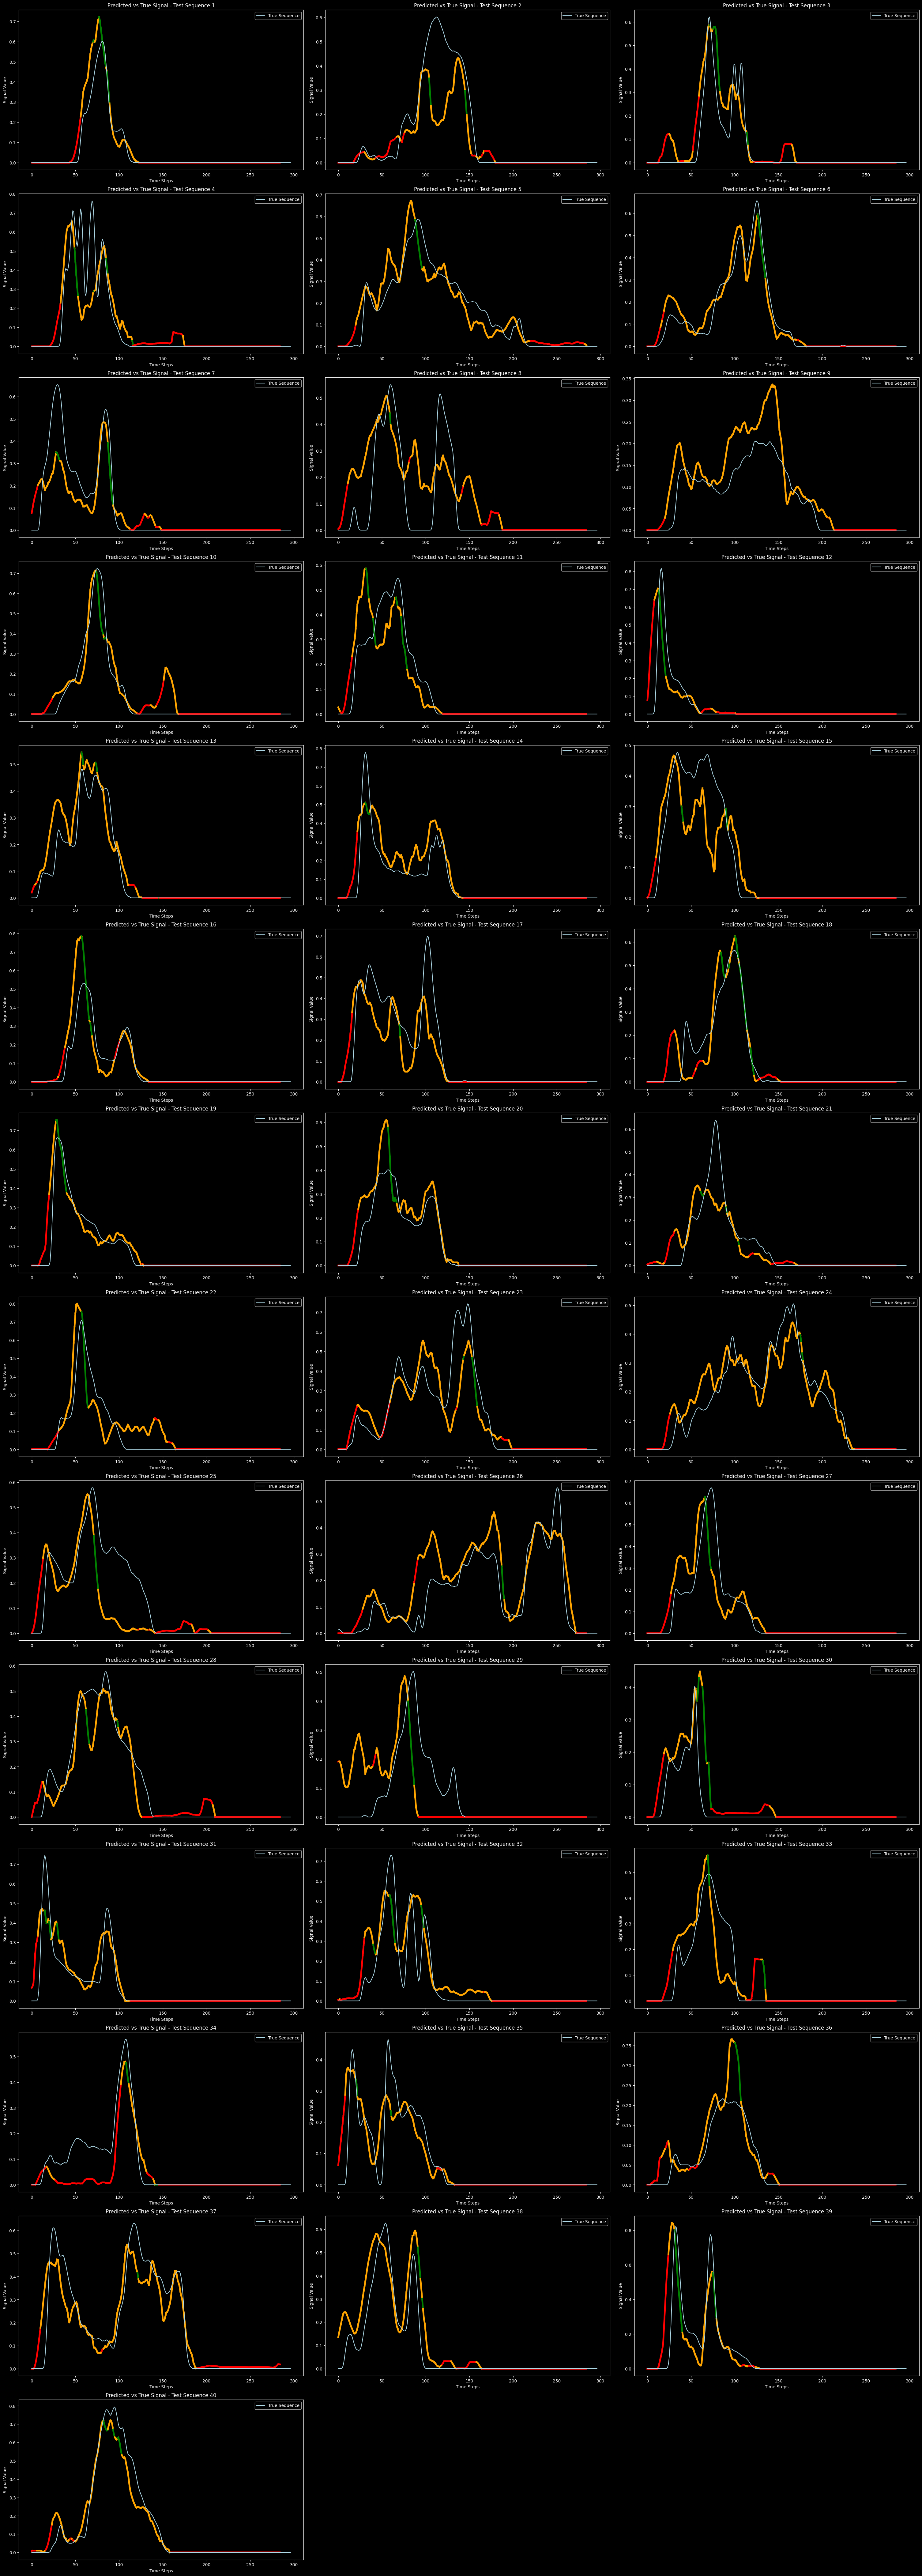

In [13]:
import numpy as np
import matplotlib.pyplot as plt


def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Make predictions using the model
predicted_sequences = model.predict(X_test)

# Replace all negative values with 0
predicted_sequences = np.maximum(predicted_sequences, 0)

# Determine the number of rows for the grid
num_rows = int(np.ceil(len(X_test) / 3))

# Create a multi-column grid with 3 columns
fig, axs = plt.subplots(num_rows, 3, figsize=(30, 6 * num_rows), constrained_layout=True)

window_size = WS  # Choose the appropriate window size for smoothing

# Define segment colors
colors = {
    0: 'red',   # no_flow
    1: 'orange',   # flow
    2: 'green',  # start
    3: 'orange', # finish
    4: 'yellow',    # max
}

for i in range(len(X_test)):
    row = i // 3
    col = i % 3

    # Get the predicted segmentation mask for the sequence
    predicted_segmentation_mask = np.argmax(predicted_sequences[i, :, 1:], axis=1)

    # predicted_sequences[i, :, 0]
    index_1 = np.where(predicted_segmentation_mask == 1)
    n1 = index_1[0][0]
    n2 = index_1[0][-1] + 1

    predicted_sequences[i, :, 0][:n1] = 0
    predicted_sequences[i, :, 0][n2:] = 0

    smoothed_predicted_sequence = moving_average(predicted_sequences[i, :, 0], window_size)

    # Plot the predicted sequence with different colors based on the predicted segment class
    for j in range(len(smoothed_predicted_sequence) - 1):
        segment_class = predicted_segmentation_mask[j]
        axs[row, col].plot([j, j+1], [smoothed_predicted_sequence[j], smoothed_predicted_sequence[j+1]],
                 color=colors[segment_class], linewidth=4)

    axs[row, col].plot(y_test[i, :, 0], label='True Sequence', c='lightblue')

    axs[row, col].set_xlabel('Time Steps')
    axs[row, col].set_ylabel('Signal Value')
    axs[row, col].legend()
    axs[row, col].set_title(f'Predicted vs True Signal - Test Sequence {i+1}')

# Remove empty subplots
for i in range(len(X_test), num_rows * 3):
    row = i // 3
    col = i % 3
    fig.delaxes(axs[row, col])

plt.show()
